#Import

In [1]:
import numpy as np
import math
import statistics
import scipy as sp
import numpy.linalg as la
from random import randint
import matplotlib.pyplot as plt
from google.colab import drive

#Function to approximate

In [2]:
def sin2(x):
    return np.sin(2*x)

#RBF

In [3]:
class Node:
    center = 0  #mu
    variance = 0 #sigma^2
    def __init__(self, center, variance):
        self.center = center
        self.variance = variance

    def transferFunction(self, input):
        if input.size == 1:
            output = math.exp((-((input - self.center)**2))/(2*self.variance))
        else:
            dist = la.norm(np.asarray(input - self.center), 2)
            output = math.exp( (-dist**2)/(2*self.variance))
        return output  


In [4]:
def RBFNodes(nbNodes, variance):
    centers = np.linspace(0, 2*math.pi, nbNodes)
    nodes = np.zeros(nbNodes, dtype=object)
    for i in range(nbNodes):
        nodes[i] = Node(centers[i], variance)
    return nodes

In [5]:
def RBFNodes2D(nbNodes, variance):
    centersx = np.linspace(0, 1, nbNodes)
    centersy = np.linspace(0, 1, nbNodes)
    centers = (np.row_stack((centersx, centersy))).T
    nodes = np.zeros(nbNodes, dtype=object)
    for i in range(nbNodes):
        nodes[i] = Node(centers[i], variance)
    return nodes

In [6]:
def RBF(patterns, targets, rbfVector, eta, weights, epochs):
    nbNodes = rbfVector.size
    for k in range(epochs):
        for i in range(len(patterns)):
            phi = np.zeros(nbNodes)
            for j in range(nbNodes):
                phi[j] = rbfVector[j].transferFunction(patterns[i])
            f = (phi.T).dot(weights)
            deltaW = eta * (targets[i] - f) * phi
            weights = weights + deltaW
    return weights

In [7]:
def RBF2D(patterns, targets, rbfVector, eta, weights, epochs):
    nbNodes = rbfVector.size
    for k in range(epochs):
        for i in range(len(patterns)):
            phi = np.zeros((nbNodes, 2), dtype=float)
            for j in range(nbNodes):
                phi[j] = rbfVector[j].transferFunction(patterns[i])
            f = (phi.T).dot(weights)
            dotted = phi.dot(targets[i]-f)
            deltaW = eta * (phi.dot(targets[i]-f))
            weights = weights + deltaW
    return weights

In [8]:
def fit(input, rbfVector, weights):
    nbNodes = rbfVector.size
    output = np.zeros(len(input))
    for i in range(len(input)):
            phi = np.zeros(nbNodes)
            for j in range(nbNodes):
                phi[j] = rbfVector[j].transferFunction(input[i])
            output[i] = (phi.T).dot(weights)
    return output

In [9]:
def fit2D(input, rbfVector, weights):
    nbNodes = rbfVector.size
    output = np.zeros((len(input), 2))
    for i in range(len(input)):
            phi = np.zeros(nbNodes, dtype=float)
            for j in range(nbNodes):
                phi[j] = rbfVector[j].transferFunction(input[i])
            output[i] = (phi.T).dot(weights)
    return output

In [10]:
def errorEstimate(targets, outputs):
    return statistics.mean((targets - outputs)**2)

In [11]:
def errorEstimate2D(targets, outputs):
    return la.norm((targets-outputs)**2)

#Competitive Learning

##1D

In [12]:
def CLInitialize(patterns, nbNodes, epochs, eta, variance=.1):
    clVector = RBFNodes(nbNodes, variance)
    for i in range(epochs):
        vectIndex = randint(0, len(patterns)-1)
        winnerValue = math.inf
        winnerIndex = -1
        for j in range(nbNodes):
            dist = math.fabs(patterns[vectIndex] - clVector[j].center)
            if dist < winnerValue:
                winnerIndex = j
                winnerValue = dist
        clVector[winnerIndex].center += eta*(patterns[vectIndex] - clVector[j].center)
    return clVector

In [13]:
def CLLeakyInitialize(patterns, nbNodes, epochs, eta, etaL=.01, variance=.1):
    clVector = RBFNodes(nbNodes, variance)
    for i in range(epochs):
        vectIndex = randint(0, len(patterns)-1)
        winnerValue = math.inf
        winnerIndex = -1
        for j in range(nbNodes):
            dist = math.fabs(patterns[vectIndex] - clVector[j].center)
            if dist < winnerValue:
                winnerIndex = j
                winnerValue = dist
        for i in range(nbNodes):
            if j == winnerIndex:
                clVector[j].center += eta*(patterns[vectIndex] - clVector[winnerIndex].center)
            else:
                clVector[j].center += etaL*(patterns[vectIndex] - clVector[winnerIndex].center)
    return clVector

##2D

In [14]:
def CLLeaky2D(patterns, targets, nbNodes, eta, etaL=.01, epochs=1000, variance=.1):
    clVector = RBFNodes2D(nbNodes, variance)
    for i in range(epochs):
        vectIndex = randint(0, len(patterns)-1)
        winnerValue = math.inf
        winnerIndex = -1
        for j in range(nbNodes):
            dist = la.norm(np.asarray(patterns[vectIndex] - clVector[j].center), 2)
            if dist < winnerValue:
                winnerIndex = j
                winnerValue = dist
        for j in range(nbNodes):
            if j==winnerIndex:
                clVector[winnerIndex].center += eta*(patterns[vectIndex]-clVector[winnerIndex].center)
            else:
                clVector[j].center += etaL*(patterns[vectIndex]-clVector[winnerIndex].center)
    return clVector

#1D

## Data initialisation

In [57]:
nbRBFNodes = 20
epochs = 100
eta = 0.01
variance = .1
weights = .1 * np.random.randn(nbRBFNodes)

patterns = (np.arange(0, 2*math.pi, 0.1)).T
targets = ((np.vectorize(sin2))(patterns)).T

testPatterns = (np.arange(0.05, 2*math.pi, 0.1)).T
testTargets = ((np.vectorize(sin2))(testPatterns)).T

## Without Noisy

###Train

In [16]:
rbfVector = CLInitialize(patterns, nbRBFNodes, epochs, eta)
weights = RBF(patterns, targets, rbfVector, eta, weights, epochs)

###Fit

In [17]:
output = fit(testPatterns, rbfVector, weights)

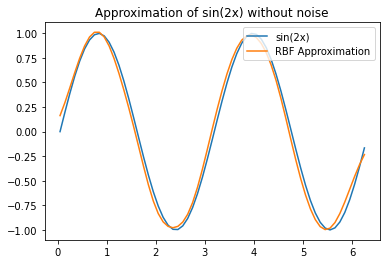

In [18]:
fig, ax = plt.subplots()
ax.plot(testPatterns, targets, label = "sin(2x)")
ax.plot(testPatterns, output, label = "RBF Approximation")
plt.title("Approximation of sin(2x) without noise")
ax.legend(loc='upper right')


In [19]:
errorRBF = np.zeros(4)
errorCL = np.zeros(4)
listNodes = [5, 10, 15, 20]
for i in range(4):
    nbRBFNodes = listNodes[i]
    rbfVector = RBFNodes(nbRBFNodes, variance)
    clVector = CLInitialize(patterns, nbRBFNodes, epochs, eta)
    weights = .1 * np.random.randn(nbRBFNodes)
  
    weightsRBF = RBF(patterns, targets, rbfVector, eta, weights, epochs)
    outputRBF = fit(testPatterns, rbfVector, weightsRBF)
    errorRBF[i] = errorEstimate(testTargets, outputRBF)
   
    weightsCL = RBF(patterns, targets, clVector, eta, weights, epochs)
    outputCL = fit(testPatterns, clVector, weightsCL)
    errorCL[i] = errorEstimate(testTargets, outputCL)

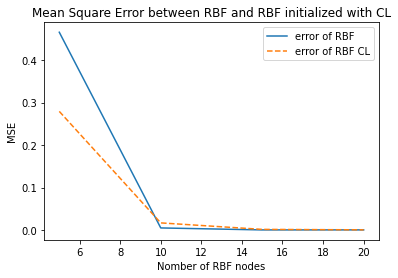

In [20]:
fig, ax = plt.subplots()
ax.plot(listNodes, errorRBF, label="error of RBF")
ax.plot(listNodes, errorCL, '--', label="error of RBF CL")
plt.xlabel("Nomber of RBF nodes")
plt.ylabel("MSE")
plt.title("Mean Square Error between RBF and RBF initialized with CL")
ax.legend(loc='upper right')


##With noise

In [58]:
noise = np.random.normal(0, 0.2, size=patterns.size)
patternsNoise = patterns + noise
targetsNoise = ((np.vectorize(sin2))(patternsNoise)).T

testPatternsNoise = testPatterns + noise
testTargetsNoise = ((np.vectorize(sin2))(testPatternsNoise)).T

###Train

In [60]:
rbfVectorNoise = CLInitialize(patternsNoise, nbRBFNodes, epochs, eta)
weightsNoise = RBF(patternsNoise, targetsNoise, rbfVectorNoise, eta, weights, epochs)

###Fit

In [61]:
outputNoise = fit(testPatternsNoise, rbfVectorNoise, weightsNoise)

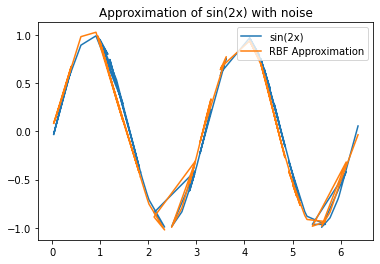

In [24]:
fig, ax = plt.subplots()
ax.plot(testPatternsNoise, targetsNoise, label = "sin(2x)")
ax.plot(testPatternsNoise, outputNoise, label = "RBF Approximation")
plt.title("Approximation of sin(2x) with noise")
ax.legend(loc='upper right')

Text(0.5, 0.98, 'Approximation of sin(2x) without noise VS with noise')

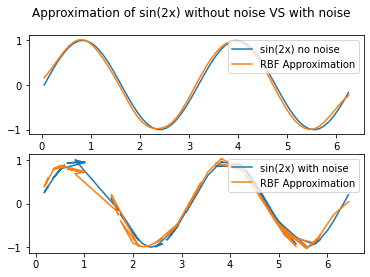

In [62]:
fig, axs = plt.subplots(2)
axs[0].plot(testPatterns, targets, label = "sin(2x) no noise")
axs[0].plot(testPatterns, output, label = "RBF Approximation")
axs[0].legend(loc='upper right')
axs[1].plot(testPatternsNoise, targetsNoise, label = "sin(2x) with noise")
axs[1].plot(testPatternsNoise, outputNoise, label = "RBF Approximation")
axs[1].legend(loc='upper right')
fig.suptitle("Approximation of sin(2x) without noise VS with noise")

In [63]:
errorRBFnoise = np.zeros(4)
errorCLnoise = np.zeros(4)
listNodes = [5, 10, 15, 20]
for i in range(4):
    nbRBFNodes = listNodes[i]
    rbfVectorNoise = RBFNodes(nbRBFNodes, variance)
    clVectorNoise = CLInitialize(patternsNoise, nbRBFNodes, epochs, eta)
    weights = .1 * np.random.randn(nbRBFNodes)

    weightsRBFnoise = RBF(patternsNoise, targetsNoise, rbfVectorNoise, eta, weights, epochs)
    outputRBFNoise = fit(testPatternsNoise, rbfVectorNoise, weightsRBFnoise)
    errorRBFnoise[i] = errorEstimate(testTargetsNoise, outputRBFNoise)
    
    weightsCLnoise = RBF(patternsNoise, targetsNoise, clVectorNoise, eta, weights, epochs)
    outputCLnoise = fit(testPatternsNoise, clVectorNoise, weightsCLnoise)
    errorCLnoise[i] = errorEstimate(testTargetsNoise, outputCLnoise)


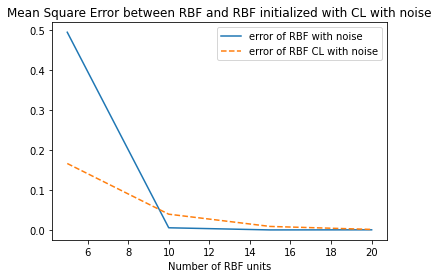

In [64]:
fig, ax = plt.subplots()
ax.plot(listNodes, errorRBFnoise, label="error of RBF with noise")
ax.plot(listNodes, errorCLnoise, '--', label="error of RBF CL with noise")
plt.title("Mean Square Error between RBF and RBF initialized with CL with noise")
plt.xlabel("Number of RBF units")
ax.legend(loc='upper right')

##Leaky CL

In [56]:
rbfVectorLeaky = CLLeakyInitialize(patterns, nbRBFNodes, epochs, eta)
weightsLeaky = RBF(patterns, targets, rbfVectorLeaky, eta, weights, epochs)

In [29]:
outputLeaky = fit(testPatterns, rbfVectorLeaky, weightsLeaky)

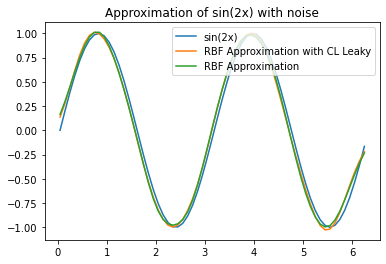

In [30]:
fig, ax = plt.subplots()
ax.plot(testPatterns, targets, label = "sin(2x)")
ax.plot(testPatterns, outputLeaky, label = "RBF Approximation with CL Leaky")
ax.plot(testPatterns, output, label = "RBF Approximation")
plt.title("Approximation of sin(2x) with noise")
ax.legend(loc='upper right')

In [54]:
errorLeakynoise = np.zeros(4)
errorCLnoise2 = np.zeros(4)
listNodes2 = [5, 10, 15, 50]
for i in range(4):
    nbRBFNodes = listNodes2[i]
    weights = .1 * np.random.randn(nbRBFNodes)

    clVectorNoise = CLInitialize(patternsNoise, nbRBFNodes, epochs, eta)
    weightsCLnoise = RBF(patternsNoise, targetsNoise, clVectorNoise, eta, weights, epochs)
    outputCLnoise = fit(testPatternsNoise, clVectorNoise, weightsCLnoise)
    errorCLnoise2[i] = errorEstimate(testTargetsNoise, outputCLnoise)

    rbfVectorLeaky = CLLeakyInitialize(patternsNoise, nbRBFNodes, epochs, eta)
    weightsLeaky = RBF(patternsNoise, targetsNoise, rbfVectorLeaky, eta, weights, epochs)
    outputLeaky = fit(testPatternsNoise, rbfVectorLeaky, weightsLeaky)
    errorLeakynoise[i] = errorEstimate(testTargetsNoise, outputLeaky)

Text(0, 0.5, 'MSE')

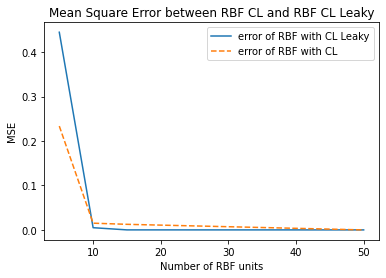

In [55]:
fig, ax = plt.subplots()

ax.plot(listNodes2, errorLeakynoise, label="error of RBF with CL Leaky")
ax.plot(listNodes2, errorCLnoise2, '--', label="error of RBF with CL")
ax.legend(loc='upper right')
plt.title("Mean Square Error between RBF CL and RBF CL Leaky")

plt.xlabel("Number of RBF units")
plt.ylabel("MSE")

#2D

In [33]:
drive.mount('/content/drive')

Mounted at /content/drive


In [34]:
angles = []
velocities = []
distances = []
heights = []

with open("/content/drive/My Drive/KTH/NeuralNetwork/Lab2/ballist.dat", "r+") as f:
    data = f.readlines()
    for line in data:
        words = line.split()
        angles.append(float(words[0]))
        velocities.append(float(words[1]))
        distances.append(float(words[2]))
        heights.append(float(words[3]))
angles = np.asarray(angles)
velocities = np.asarray(velocities)
distances = np.asarray(distances)
heights = np.asarray(heights)

inputs = np.column_stack((angles, velocities))
targets = np.column_stack((distances, heights))


In [35]:
anglesT = []
velocitiesT = []
distancesT = []
heightsT = []

with open("/content/drive/My Drive/KTH/NeuralNetwork/Lab2/balltest.dat", "r+") as f:
    data = f.readlines()
    for line in data:
        words = line.split()
        anglesT.append(float(words[0]))
        velocitiesT.append(float(words[1]))
        distancesT.append(float(words[2]))
        heightsT.append(float(words[3]))
anglesT = np.asarray(anglesT)
velocitiesT = np.asarray(velocitiesT)
distancesT = np.asarray(distancesT)
heightsT = np.asarray(heightsT)

inputsT = np.column_stack((anglesT, velocitiesT))
targetsT = np.column_stack((distancesT, heightsT))

In [36]:
nbRBFNodes = 20
clVector = CLLeaky2D(inputs, targets, nbRBFNodes, eta=0.1)
weights = (np.row_stack((.1*np.random.randn(nbRBFNodes), .1*np.random.randn(nbRBFNodes)))).T
w = RBF2D(inputs, targets, clVector, eta, weights, epochs)

In [37]:
outputs = fit2D(inputsT, clVector, w)

In [38]:
nodesX = []
nodesY = []
for i in range(nbRBFNodes):
    nodesX.append(clVector[i].center[0])
    nodesY.append(clVector[i].center[1])

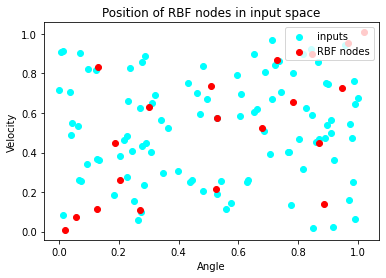

In [39]:
plt.figure()
plt.scatter(inputs.T[0], inputs.T[1], color='cyan', label="inputs")
plt.scatter(nodesX, nodesY, color='red', label="RBF nodes")
plt.title("Position of RBF nodes in input space")
plt.xlabel('Angle')
plt.ylabel('Velocity')
plt.legend(loc="upper right")
plt.show()

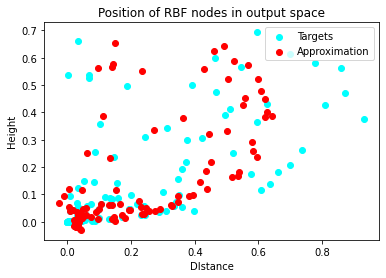

In [40]:
plt.figure()
plt.scatter(targetsT.T[0], targetsT.T[1], color='cyan', label="Targets")
plt.scatter(outputs.T[0], outputs.T[1], color='red', label="Approximation")
plt.title("Position of RBF nodes in output space")
plt.xlabel('DIstance')
plt.ylabel('Height')
plt.legend(loc='upper right')
plt.show()

In [41]:
errorCL2D = np.zeros(6)
listNodes = [5, 10, 15, 25, 50, 100]
for i in range(6):
    nbRBFNodes = listNodes[i]
    clVector = CLLeaky2D(inputs, targets, nbRBFNodes, eta=0.1)
    weights = (np.row_stack((.1*np.random.randn(nbRBFNodes), .1*np.random.randn(nbRBFNodes)))).T
    w = RBF2D(inputs, targets, clVector, eta, weights, epochs)

    outputs2D = fit2D(inputsT, clVector, w)
    errorCL2D[i] = errorEstimate2D(targetsT, outputs2D)

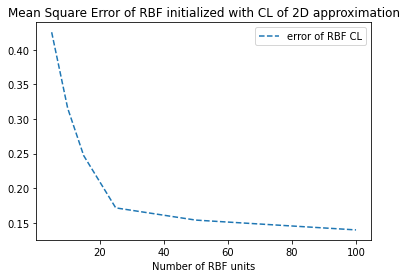

In [43]:
fig, ax = plt.subplots()
ax.plot(listNodes, errorCL2D, '--', label="error of RBF CL")
plt.xlabel("Number of RBF units")
plt.title("Mean Square Error of RBF initialized with CL of 2D approximation")
ax.legend(loc='upper right')